In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils import get_data, get_probabilities, estimate_q_Z_given_A, get_probabilities_one_hot
from sklearn.decomposition import NMF  # Placeholder for volmin factorization
from volmin_nmf import *
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [102]:
p_source = 0.8
p_target = 0.2
total = 10000
factorisation_atol = 1e-1

# Step 2 parameters
specific_a_index = 0  # First value of A

# "sklearn" for sklearn's NMF
# "volmin_1" for volmin NMF, adapted from https://github.com/kharchenkolab/vrnmf
# "volmin_2" for volmin NMF, adapted from https://github.com/bm424/mvcnmf/blob/master/mvcnmf.py
nmf_method = "volmin_2" 
# parameters for volmin NMF
w_vol = 5
delta = 1e-8
n_iter = 100000
err_cut = 1e-8

In [103]:
# 2x2 matrix
theta_w_epsilon = torch.tensor([
    [-1, 1],
    [1, -1]
])

# 2x2 matrix
theta_z_epsilon = torch.tensor([
    [1, -1],
    [-1, 1]
])

theta_a_z_epsilon = torch.tensor([
    [1, -1],
    [-1, 1],
    [1, -1]
]) #negate when epsilon is 1

# 1x5 matrix concatenating 1 hot of w and a. Negate when epsilon is 1. a is 3D and w is 2D
theta_y_a_w_epsilon = torch.tensor([
    [3, 1, -1, -1, 1]
]) 


In [104]:
def get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p=0.2):

    epsilon = torch.bernoulli(torch.tensor([p])).long() # (1,)
    epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)

    z = np.sign(epsilon_one_hot@theta_z_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)
    w = np.sign(epsilon_one_hot@theta_w_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)

    # w given z and a should be perfect

    a_logits = epsilon * theta_a_z_epsilon @ z + (epsilon-1) * theta_a_z_epsilon @ z #epsilon is 0 or 1, theta_a_z_epsilon is 3x2, z is [2]. So result is 3x1
    a = torch.bernoulli(torch.sigmoid(a_logits)).float().squeeze() # a is size 3

    # concatenate w and a
    # then similar but use different matrix and w,a instead of z
    wa = torch.cat((w, a), dim=0) # [5]

    y_logits = epsilon * theta_y_a_w_epsilon @ wa.long() + (epsilon-1) * theta_y_a_w_epsilon @ wa.long() # y is a function of a, w and epsilon from the graph
    y = torch.bernoulli(torch.sigmoid(y_logits).squeeze()).float()

    return epsilon,z,w,a,y

def get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p, total):
    U,Z,W,X,Y = [],[],[],[],[]
    for _ in range(total):
        u,z,w,x,y = get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p)
        U.append(u)
        Z.append(z)
        W.append(w)
        X.append(x)
        Y.append(y)

    return U,Z,W,X,Y

def get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total):
    
    # Source distribution data
    U_source, Z_source, W_source, X_source, Y_source = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, total)
    
    # Target distribution data
    U_target, Z_target, W_target, X_target, Y_target = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, total)
    
    return (Z_source, U_source, W_source, X_source, Y_source), \
           (Z_target, U_target, W_target, X_target, Y_target)

In [105]:
source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total)
Z_source, epsilon_source, W_source, A_source, Y_source = source_data
Z_target, epsilon_target, W_target, A_target, Y_target = target_data

/var/folders/tf/g242212x4tsbkxq6k9xkfvn80000gn/T/ipykernel_29702/1081166918.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)


In [106]:
sum(Y_source) # Y_source is almost all 1 for some reason

tensor(7757.)

In [107]:
print("Y_source.shape", len(Y_source))
print("W_source.shape", len(W_source))
print("A_source.shape", len(A_source))
print("Z_source.shape", len(Z_source))

print("Y_source", Y_source)
print("W_source", W_source)
print("A_source", A_source)
print("Z_source", Z_source)

Y_source.shape 10000
W_source.shape 10000
A_source.shape 10000
Z_source.shape 10000
Y_source [tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor

In [108]:
def plot_histograms(data, label):
    Z, epsilon, W, A, Y = data

    # Convert tensors to numpy arrays
    Z_np = np.array(Z)
    epsilon_np = np.array(epsilon)
    W_np = np.array(W)
    A_np = np.array(A)
    Y_np = np.array(Y)

    # Flatten the arrays for histogram plotting
    Z_flat = Z_np.flatten()
    epsilon_flat = epsilon_np.flatten()
    W_flat = W_np.flatten()
    A_flat = A_np.flatten()
    Y_flat = Y_np.flatten()

    # Plot histograms
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 3, 1)
    plt.hist(Z_flat, bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of Z_{label}')

    plt.subplot(2, 3, 2)
    plt.hist(epsilon_flat, bins=20, color='green', alpha=0.7)
    plt.title(f'Histogram of epsilon_{label}')

    plt.subplot(2, 3, 3)
    plt.hist(W_flat, bins=20, color='red', alpha=0.7)
    plt.title(f'Histogram of W_{label}')

    plt.subplot(2, 3, 4)
    plt.hist(A_flat, bins=20, color='purple', alpha=0.7)
    plt.title(f'Histogram of A_{label}')

    plt.subplot(2, 3, 5)
    plt.hist(Y_flat, bins=20, color='orange', alpha=0.7)
    plt.title(f'Histogram of Y_{label}')

    plt.tight_layout()
    plt.show()


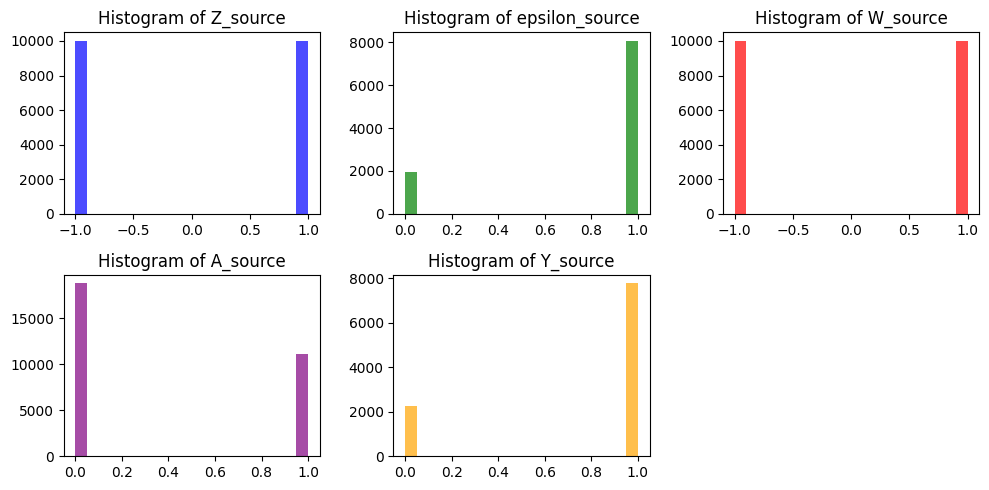

In [109]:
plot_histograms(source_data, "source")

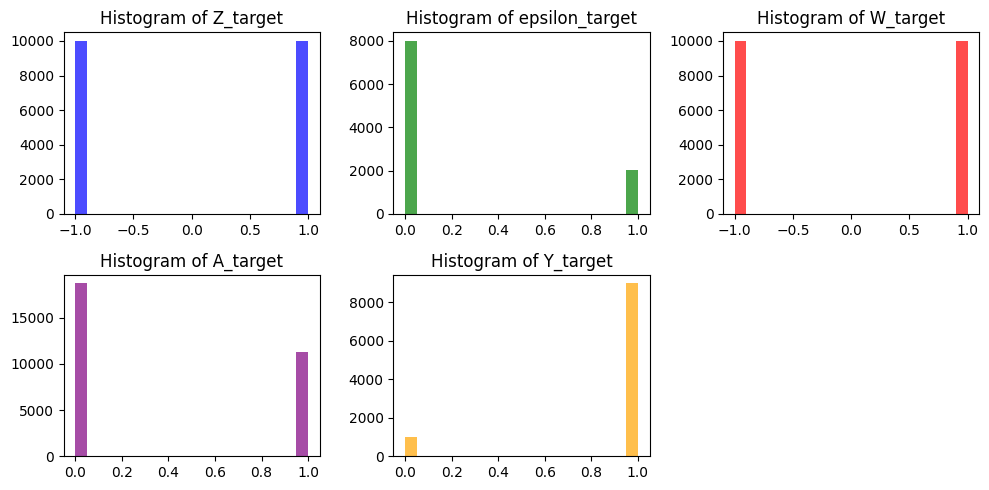

In [110]:
plot_histograms(target_data, "target")

In [111]:
# def flatten_and_convert(tensor_list):
#     # Concatenate list of tensors and convert to NumPy array
#     concatenated_tensor = torch.cat(tensor_list, dim=0)
#     numpy_array = concatenated_tensor.numpy()
#     return numpy_array

# def plot_distributions(Z_source, W_source, A_source, Y_source):
#     combinations = list(itertools.product(range(4), range(4)))
    
#     plt.figure(figsize=(20, 20))
    
#     # Convert one-hot encoded tensors to indices directly
#     Z_indices = np.argmax(flatten_and_convert(Z_source), axis=1).flatten()
#     A_indices = np.argmax(flatten_and_convert(A_source), axis=1).flatten()
#     Y_indices = flatten_and_convert(Y_source).flatten()  # Y_source is already binary, just flatten it
#     W_indices = np.argmax(flatten_and_convert(W_source), axis=1).flatten()

#     print(Y_indices.shape)
    
#     # Print the first few indices for debugging
#     print("Z_indices (first 10):", Z_indices[:10])
#     print("A_indices (first 10):", A_indices[:10])
#     print("Y_indices (first 10):", Y_indices[:10])
#     print("W_indices (first 10):", W_indices[:10])
    
#     for i, (z_val, a_val) in enumerate(combinations):
#         indices = (Z_indices == z_val) & (A_indices == a_val)
        
#         Y_subsample = Y_indices[indices]
#         W_subsample = W_indices[indices]
        
#         plt.subplot(8, 4, 2 * i + 1)
#         plt.hist(Y_subsample, bins=np.arange(3) - 0.5, color='orange', alpha=0.7)
#         plt.title(f'Y | Z={z_val}, A={a_val}')
#         plt.xticks([0, 1])
        
#         plt.subplot(8, 4, 2 * i + 2)
#         plt.hist(W_subsample, bins=np.arange(5) - 0.5, color='blue', alpha=0.7)
#         plt.title(f'W | Z={z_val}, A={a_val}')
#         plt.xticks([0, 1, 2, 3])
    
#     plt.tight_layout()
#     plt.show()

# plot_distributions(Z_source, W_source, A_source, Y_source)

In [112]:
num_classes_Y = 2 
num_classes_W = 2
num_features_Z = 2
num_features_A = 3

sum_epsilon = np.sum(epsilon_source)
print("Sum of epsilon_source:", sum_epsilon.item())

sum_Y = np.sum(Y_source)
print("Sum of Y_source:", sum_Y.item())

Sum of epsilon_source: 8061
Sum of Y_source: 7757.0


In [113]:
# =============================================================================
# Step 1: Estimate p(Y|Z,a) and p(W|Z,a)
# =============================================================================

# Train model to estimate p(Y|Z,a)
# By stacking with A, we condition on A by including all values of A in the input
ZA_source = np.hstack((Z_source, A_source))  # We go from 4 features to 4 + 4 = 8 features
# if step1_debug:
#     print("ZA_source.shape", ZA_source.shape)  # Debug print statement
#     print("ZA_source", ZA_source)  # Debug print statement

############### LOGISTIC REGRESSION VERSION ###############

#model_Y = LogisticRegression(input_dim=ZA_source.shape[1], num_classes=2)
#model_Y.train(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32))

# model_Y = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=Y_source.shape[1])
# model_Y.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)
# p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)

In [114]:
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, 16)
#         self.fc5 = nn.Linear(16, output_dim)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc4(x))
#         x = self.dropout(x)
#         x = self.fc5(x)
#         return x
    
# def train_nn(model, X, Y, learning_rate=0.001, epochs=50, batch_size=32):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
#     dataset = torch.utils.data.TensorDataset(X, Y)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
#     for epoch in range(epochs):
#         for batch_X, batch_Y in dataloader:
#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_Y)
#             loss.backward()
#             optimizer.step()
#         if (epoch+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# def eval_nn(model, X, Y):
#     with torch.no_grad():
#         outputs = model(X)
#         _, predicted = torch.max(outputs, 1)
#         correct = (predicted == Y).sum().item()
#         accuracy = correct / Y.size(0)
#     return accuracy

In [115]:
# # Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_Y = SimpleNN(input_dim, num_classes_Y)
# train_nn(model_Y, torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source.flatten(), dtype=torch.long), learning_rate=0.001, epochs=500, batch_size=16)

# # Evaluate the model
# accuracy_nn = eval_nn(model_Y, torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source.flatten(), dtype=torch.long))
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')

In [116]:
############### SKLEARN VERSION ###############

# print("Y_source flatten", Y_source.flatten())
ZA_source

##### LOGISTIC REGRESSION #####
# model_Y = SklearnLogisticRegression(max_iter=1000)
# model_Y.fit(ZA_source, Y_source)

##### GRAIDENT BOOSTING #####
# model_Y = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=0)
# model_Y.fit(ZA_source, Y_source)

##### RANDOM FOREST #####
# model_Y = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
# model_Y.fit(ZA_source, Y_source)

##### NEURAL NETWORK #####
model_Y = MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
model_Y.fit(ZA_source, Y_source)


print(ZA_source)
print(Y_source)
Y_train_pred = model_Y.predict(ZA_source)
print("Y_train_pred",Y_train_pred)

Y_train_true = Y_source
accuracy_Y_train = np.mean(Y_train_pred == Y_source)
print(f"Accuracy of model_Y on training set: {accuracy_Y_train:.4f}")


[[-1.  1.  0.  1.  1.]
 [-1.  1.  0.  1.  0.]
 [-1.  1.  0.  1.  0.]
 ...
 [-1.  1.  0.  1.  1.]
 [-1.  1.  0.  0.  0.]
 [-1.  1.  1.  1.  0.]]
[tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), ten

In [117]:
cm = confusion_matrix(Y_source, model_Y.predict(ZA_source))
print("Classification Report:")
print(classification_report(Y_source, model_Y.predict(ZA_source)))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.17      0.25      2243
         1.0       0.80      0.95      0.87      7757

    accuracy                           0.78     10000
   macro avg       0.65      0.56      0.56     10000
weighted avg       0.73      0.78      0.73     10000



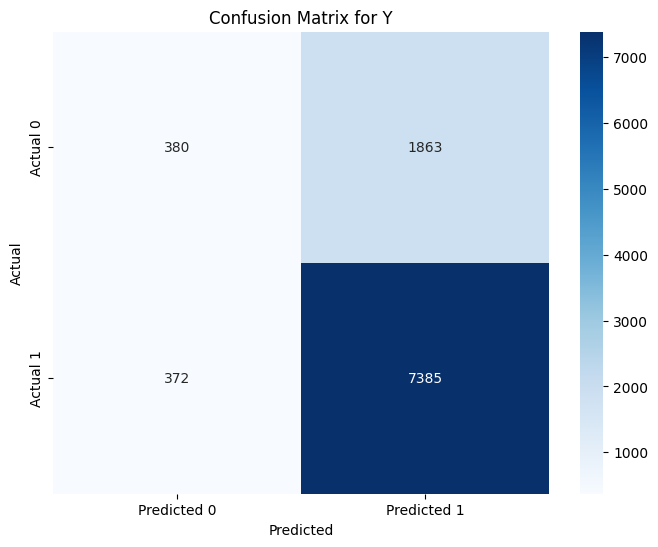

In [118]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Y')
plt.show()

In [119]:
# def get_probabilities_one_hot_nn(model, Z, A):
#     """
#     Computes the softmax probabilities from the trained model.
    
#     Args:
#         model (model): Trained model.
#         Z (numpy.ndarray): Feature matrix Z.
#         A (numpy.ndarray): Feature matrix A.

#     Returns:
#         numpy.ndarray: Probability matrix reshaped to (|Z|, |A|, |Y|) or (|Z|, |A|, |W|).
#     """
#     num_Z = Z.shape[1]
#     num_A = A.shape[1]
#     num_classes = model.fc5.out_features #number of layers here

#     # Generate all possible one-hot vectors for Z
#     possible_Z = np.eye(num_Z)
#     possible_A = np.eye(num_A)
    
#     probabilities = []
    
#     for z in possible_Z:
#         for a in possible_A:
#             ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
#             ZA_tensor = torch.tensor(ZA, dtype=torch.float32)
#             with torch.no_grad():
#                 probs = model(ZA_tensor)
#                 probs = torch.softmax(probs, dim=1).numpy()
#                 probabilities.append(probs[0])
    
#     probabilities = np.array(probabilities).reshape((num_Z, num_A, num_classes))
    
#     return probabilities

In [120]:

# p_Y_given_ZA = get_probabilities_one_hot_nn(model_Y, Z_source, A_source)
# print("p_Y_given_ZA", p_Y_given_ZA)
# print("p_Y_given_ZA shape:", p_Y_given_ZA.shape)  # Debug print statement


In [121]:

# # Verify the shape of p_Y_given_ZA
# assert p_Y_given_ZA.shape == (num_features_Z, num_features_A, num_classes_Y), f"p_Y_given_ZA shape mismatch: {p_Y_given_ZA.shape}"
# assert np.allclose(p_Y_given_ZA.sum(axis=2), 1.0), "p_Y_given_ZA rows do not sum to 1"
# print("Step 1: p_Y_given_ZA shape and sum are correct.")



In [122]:
# W_source_indices = torch.argmax(torch.tensor(W_source), dim=1)
# print(W_source)
# print(W_source_indices)

In [123]:
#convert to binary

def tensor_to_binary(tensor):
    return 1 if tensor[0] == 1 else 0

# Convert the list of tensors to a list of binary labels
binary_labels = [tensor_to_binary(t) for t in W_source]

# Convert to numpy array (optional)
binary_labels_array = np.array(binary_labels)

In [124]:
############### LOGISTIC REGRESSION VERSION ###############
#Train model to estimate p(W|Z,a)
# model_W = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=W_source.shape[1])
# model_W.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)

# p_W_given_ZA = get_probabilities_one_hot(model_W, Z_source, A_source)



############### SKLEARN VERSION ###############

# model_W = SklearnLogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
# model_W.fit(ZA_source, np.argmax(W_source, axis=1))
# W_train_pred = model_W.predict(ZA_source)
# W_train_true = np.argmax(W_source, axis=1)
# accuracy_W_train = np.mean(W_train_pred == W_train_true)
# print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")
#p_W_given_ZA = model_W.predict_proba(ZA_source).reshape(num_features_Z, num_features_A, num_classes_W)

model_W= SklearnLogisticRegression(max_iter=1000)
model_W.fit(ZA_source, binary_labels_array)

# print(ZA_source)
# print(W_source)
W_train_pred = model_W.predict(ZA_source)
print("W_train_pred",W_train_pred)

W_train_true = W_source
accuracy_W_train = np.mean(W_train_pred == binary_labels_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")



############### NEURAL NETWORK VERSION ###############

# Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_W = SimpleNN(input_dim, num_classes_W)
# train_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices, learning_rate=0.001, epochs=500, batch_size=16)

# # Evaluate the model
# accuracy_nn = eval_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices)
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')


W_train_pred [1 1 1 ... 1 1 1]
Accuracy of model_W on training set: 1.0000


In [125]:
cm_w = confusion_matrix(binary_labels_array, model_W.predict(ZA_source))
print("Classification Report for W:")
print(classification_report(binary_labels_array, model_W.predict(ZA_source)))

Classification Report for W:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      1.00      1.00      8061

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



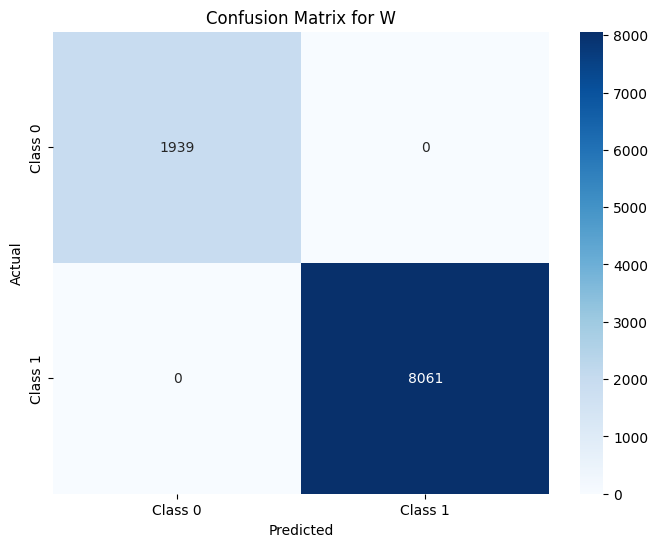

In [126]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for W')
plt.show()

In [127]:
# p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)

# if step1_debug:
#     print("p_W_given_ZA shape:", p_W_given_ZA.shape)  # Debug print statement
#     print("p_W_given_ZA", p_W_given_ZA)  # Debug print statement

# # Verify the shape of p_W_given_ZA
# assert p_W_given_ZA.shape == (num_features_Z, num_features_A, num_classes_W), f"p_W_given_ZA shape mismatch: {p_W_given_ZA.shape}"
# assert np.allclose(p_W_given_ZA.sum(axis=2), 1.0), "p_W_given_ZA rows do not sum to 1"
# if step1_debug:
#     print("Step 1: p_W_given_ZA shape and sum are correct.")

# print("STEP 1 DONE")